This notebook explores the ocean model simulation used as an input to the generator.
We make use of the Southern Ocean Regionally Refined Mesh v 2.1 run of the E3SM / MPAS-Ocean model, a 1000 year simulation of the ocean circulation, provided at a monthly resolution.
The notebook uses `dask` to chunk this dataset throughout the workflow to enable scalable computation.

In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [2]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53308,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53326,Total threads: 2
Dashboard: http://127.0.0.1:53330/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:53311,


In [3]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent

dir_ext_data = 'data/external/'
dir_interim_data = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'

# Ice shelf basin/catchment definitions
FILE_iceShelvesShape = 'iceShelves.geojson'

In [4]:
# File path directories

inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_basalMeltObs = 'ANT_G1920V01_IceShelfMelt.nc'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'


FILE_iceShelvesShape = 'iceShelves.geojson'

In [ ]:
SORRMv21 = xr.open_dataset(main_dir / DIR_SORRMv21 / FILE_SORRMv21, chunks={"Time":36})

ICESHELVES_MASK = gpd.read_file(main_dir / dir_ext_data / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

In [15]:
MELTDRAFT_OBS = xr.open_dataset(inDirName+DIR_basalMeltObs+FILE_MeltDraftObs)

In [7]:
t1=350
t2=650
flux = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[t1*12:t2*12]
# ssh = SORRMv21.timeMonthly_avg_ssh

In [16]:
obs23 = MELTDRAFT_OBS.melt

### Detrend and deseasonalize data

In [9]:
# Linear trend, if any
# Debug for dask implementation, a "consistent source of headaches".
# https://ncar.github.io/esds/posts/2022/dask-debug-detrend/

def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [10]:
p = flux.polyfit(dim='Time',deg=1)
p.polyfit_coefficients

<xarray.DataArray 'polyfit_coefficients' (degree: 2, y: 601, x: 601)>
dask.array<reshape, shape=(2, 601, 601), dtype=float64, chunksize=(2, 601, 601), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * x        (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * degree   (degree) int64 1 0

In [11]:
fit = xr.polyval(flux['Time'], p.polyfit_coefficients)

In [12]:
dim = 'Time'
data = flux
chunked_dim = xr.DataArray(dask.array.from_array(data[dim].data, chunks=data.chunksizes[dim]), dims=dim, name=dim)

In [21]:
# polyval function defined below does not work for a Datetime vector time dimension, only for integers. 
# TODO: Modify function to convert that to a vector of floats or ints.

def polyval(coord, coeffs, degree_dim="degree"):
    x = np.array(range(12000))# coord.data

    deg_coord = coeffs[degree_dim]
    N = int(deg_coord.max()) + 1

    lhs = xr.DataArray(
        np.stack([x ** (N - 1 - i) for i in range(N)], axis=1),
        dims=(coord.name, degree_dim),
        coords={coord.name: coord, degree_dim: np.arange(deg_coord.max() + 1)[::-1]},
    )
    return (lhs * coeffs).sum(degree_dim)

# Function to detrend
# Modified from source: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(da, dim, deg=1):
    """detrend along a single dimension."""
    # calculate polynomial coefficients
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # first create a chunked version of the "ocean_time" dimension
    chunked_dim = xr.DataArray(dask.array.from_array(da[dim].data, chunks=da.chunksizes[dim]), dims=dim, name=dim)
    fit = polyval(chunked_dim, p.polyfit_coefficients)
    # evaluate trend
    # remove the trend
    return da - fit

In [28]:
p = flux.polyfit(dim='Time', deg=1, skipna=False)
p.polyfit_coefficients

<xarray.DataArray 'polyfit_coefficients' (degree: 2, y: 601, x: 601)>
dask.array<reshape, shape=(2, 601, 601), dtype=float64, chunksize=(2, 601, 601), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * x        (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * degree   (degree) int64 1 0

In [ ]:
flux_detrend = detrend_dim(flux,"Time")

In [70]:
# flux_detrend_computed = flux_detrend.compute()

In [ ]:
"""
import scipy.signal as sps
import scipy.linalg as spl


def detrend(da, dim, detrend_type="constant"):
    """
    Detrend a DataArray

    Parameters
    ----------
    da : xarray.DataArray
        The data to detrend
    dim : str or list
        Dimensions along which to apply detrend.
        Can be either one dimension or a list with two dimensions.
        Higher-dimensional detrending is not supported.
        If dask data are passed, the data must be chunked along dim.
    detrend_type : {'constant', 'linear'}
        If ``constant``, a constant offset will be removed from each dim.
        If ``linear``, a linear least-squares fit will be estimated and removed
        from the data.

    Returns
    -------
    da : xarray.DataArray
        The detrended data.

    Notes
    -----
    This function will act lazily in the presence of dask arrays on the
    input.
    """

    if dim is None:
        dim = list(da.dims)
    else:
        if isinstance(dim, str):
            dim = [dim]

    if detrend_type not in ["constant", "linear", None]:
        raise NotImplementedError(
            "%s is not a valid detrending option. Valid "
            "options are: 'constant','linear', or None." % detrend_type
        )

    if detrend_type is None:
        return da
    elif detrend_type == "constant":
        return da - da.mean(dim=dim)
    elif detrend_type == "linear":
        data = da.data
        axis_num = [da.get_axis_num(d) for d in dim]
        chunks = getattr(data, "chunks", None)
        if chunks:
            axis_chunks = [data.chunks[a] for a in axis_num]
            print(axis_chunks)
            if not all([len(ac) == 1 for ac in axis_chunks]):
                raise ValueError("Contiguous chunks required for detrending.")
        if len(dim) == 1:
            dt = xr.apply_ufunc(
                sps.detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
        elif len(dim) == 2:
            dt = xr.apply_ufunc(
                _detrend_2d_ufunc,
                da,
                input_core_dims=[dim],
                output_core_dims=[dim],
                output_dtypes=[da.dtype],
                vectorize=True,
                dask="parallelized",
            )
        else:  # pragma: no cover
            raise NotImplementedError(
                "Only 1D and 2D detrending are implemented so far."
            )

    return dt


def _detrend_2d_ufunc(arr):
    assert arr.ndim == 2
    N = arr.shape

    col0 = np.ones(N[0] * N[1])
    col1 = np.repeat(np.arange(N[0]), N[1]) + 1
    col2 = np.tile(np.arange(N[1]), N[0]) + 1
    G = np.stack([col0, col1, col2]).transpose()

    d_obs = np.reshape(arr, (N[0] * N[1], 1))
    m_est = np.dot(np.dot(spl.inv(np.dot(G.T, G)), G.T), d_obs)
    d_est = np.dot(G, m_est)
    linear_fit = np.reshape(d_est, N)
    return arr - linear_fit
"""

In [7]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize
def deseasonalize(data):
    data_month = data.groupby("Time.month")
    data_clm = data_month.mean("Time") # Climatologies
    data_anm = data_month - data_clm # Deseasonalized anomalies
    return data_anm

In [8]:
flux_deseasoned = deseasonalize(flux).compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 300 times more chunks
  return self.array[key]


In [53]:
flux_deseasoned_mean = flux_deseasoned.mean(['x','y']).compute()

In [ ]:
plt.figure(figsize=(26,8))
#flux_deseasoned_mean[12*200:].plot()
flux_deseasoned_mean.plot()
flux_detrended_deseasonalized.plot()

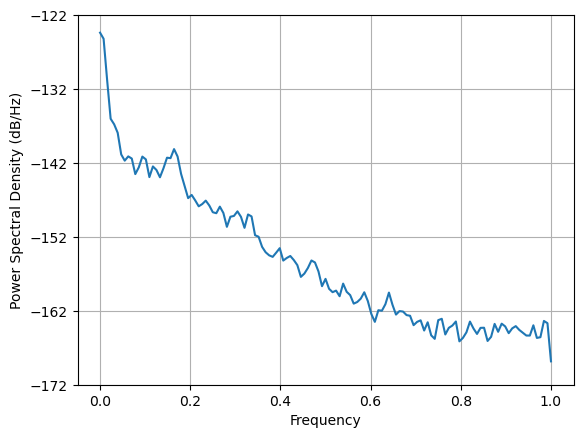

In [55]:
plt.psd(flux_deseasoned_mean);

In [9]:
flux_detrend = detrend_dim(flux_deseasoned,"Time",1)
# flux_clean = deseasonalize(flux_detrend)

In [ ]:
# flux_detrend = flux_detrend.compute()

In [62]:
flux_detrended_deseasonalized = flux_detrend.mean(['x','y']).compute()

In [65]:
flux_detrend['flux_dtrnd'] = flux_detrend

In [71]:
# flux_detrend.flux_dtrnd.to_netcdf(

### Temporal Standard Deviation

In [ ]:
# Standard deviation in time
flux_std = flux.std('Time').compute()
flux_std.where(flux_std!=0).plot()

### Temporal Mean

In [ ]:
# Time mean
flux_tmean = flux.mean('Time').compute()
flux_tmean.where(flux_std!=0).plot()

### Cumulative melt rate (across the ice sheet)

In [ ]:
flux_ts = flux.sum(['x','y']).compute()

In [ ]:
plt.figure(figsize=(25,8))
flux_ts.plot()
plt.xlabel('Time (Simulation years)')
plt.title('Freshwater Flux - AIS Cumulative')

### Mean freshwater flux in each catchment

In [ ]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    # clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
mean_flux = np.empty(len(icems[33:133]))

for i in range(33,133):
    clip_ds = clip_data(flux_tmean, i)
    mean_flux[i-33] = clip_ds.mean()

In [ ]:
# flux_tmean.rio.write_crs("epsg:3031",inplace=True);

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(mean_flux, marker='x', lw=0.0)



### EOF/PCA analysis

In [10]:
flux_detrend = flux_detrend.rename({"Time":"time"})

In [13]:
# Normalize 
flux_clean_tmean = flux_detrend.mean('time')
flux_clean_tstd = flux_detrend.std('time')

In [14]:
flux_clean_demeaned = flux_detrend - flux_clean_tmean
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
model = EOF(flux_detrend[:], n_modes=100)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

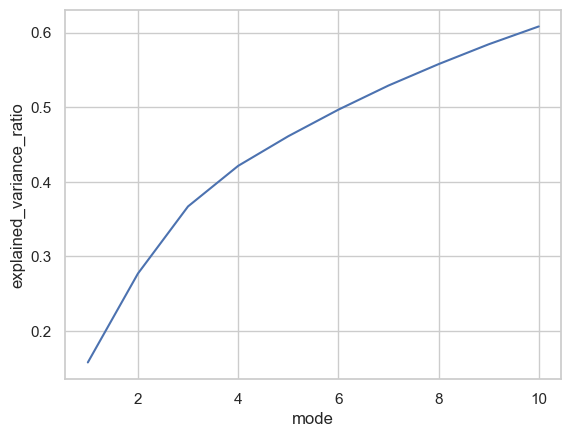

In [88]:
Fv_cs.plot()

In [68]:
obs23_na= obs23.fillna(0)

In [69]:
obsmodel = EOF(obs23_na[:], n_modes=10)
obsmodel.solve()
obs_eofs = obsmodel.eofs()
obs_pcs = obsmodel.pcs()
obs_nmodes = obsmodel.n_modes
obs_varexpl = obsmodel.explained_variance_ratio()

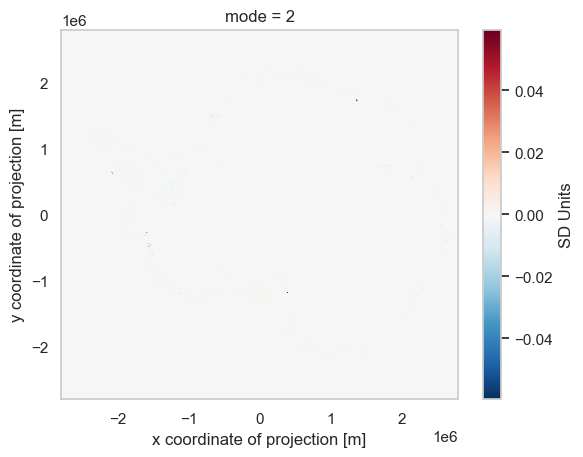

In [72]:
obs_eofs.sel(mode=2).plot(add_colorbar=True,
                          cbar_kwargs={'orientation': 'vertical','label': 'SD Units'})

In [86]:
# Cumulative variance captured
Fv_cs = varexpl.cumsum()
#Fvn_cs = norm_varexpl.cumsum()

In [ ]:
eofs.sel(mode=1).plot(add_colorbar=True,
                      cbar_kwargs={'orientation': 'vertical',
                                   'label': 'Freshwater Flux EOFs'})

In [ ]:
eofs[:,:,0:3].plot(col='mode', col_wrap=3,vmax=0.05,vmin=-0.05,cmap='RdBu_r')

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 4 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2])
axbig = fig.add_subplot(gs[0,:])
ax0 = [fig.add_subplot(gs[i,0],projection=crs) for i in range(1,nmodes_plot)]
ax1 = [fig.add_subplot(gs[i,1]) for i in range(1,nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF Mode {}'.format(i+1))
    #a1.set_ylim(-3,3)
    a1.plot(pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.set_title('PC Mode {}'.format(i+1))
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)

a1.set_xlabel('Time (months)');

m = 10
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fv_cs[:m]*100, 'k*--', lw=0.5,markersize=1.75,
         label='Actual Data: {:.2f}\%'.format(varexpl[:m].sum().values*100))
axbig.set_ylabel('Cumulative variance captured (\%)')
axbig.set_xlabel('Mode Number')
axbig.set_title('Cumulative variance captured by first {} modes'.format(m));
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend();

fig.tight_layout()